# Transformer
* 2017年,Transformer横空出世,至今已经8年时间,仍然没有新的框架可以超越
## 1.准备工作
### 1.1 机器翻译和数据集

In [54]:
import os
import torch
from d2l import torch as d2l
import zipfile

d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
    """载入"英语-法语"数据集"""
    # 指定下载目录为当前目录下的data/fra-eng文件夹
    download_dir = './data/fra-eng/'
    
    # 确保下载目录存在
    os.makedirs(download_dir, exist_ok=True)
    
    # 下载ZIP文件
    zip_path = d2l.download('fra-eng', cache_dir=download_dir)
    
    # 解压文件到当前下载目录
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(download_dir)
    
    # 正确路径应该是下载目录中的fra.txt
    data_file = os.path.join(download_dir, 'fra-eng/fra.txt')
    
    # 读取数据文件   
    with open(data_file, 'r', encoding='utf-8') as f:
        return f.read()

text = read_data_nmt()
print(text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



* 数据集预处理

In [56]:
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


* 词元化

这里使用单词级词元化而非字符级词元化

In [57]:
#@save
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

* 创建词表

In [58]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

* 截断和填充限制大小

语言预测模型中，序列样本有固定的长度，由num_steps决定，对于不同文本序列长度的数据，使用截断和填充

In [62]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

print(truncate_pad(source[0], 10, ['<pad>']))
truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

['go', '.', ['<pad>'], ['<pad>'], ['<pad>'], ['<pad>'], ['<pad>'], ['<pad>'], ['<pad>'], ['<pad>']]


[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

* 将文本序列转换成小批量数据集

In [70]:
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

* 整合上述功能返回数据迭代器

In [72]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [75]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

X: tensor([[ 6, 50,  8,  4,  3,  1,  1,  1],
        [83, 15,  4,  3,  1,  1,  1,  1]], dtype=torch.int32)
X的有效长度: tensor([5, 4])
Y: tensor([[6, 0, 4, 3, 1, 1, 1, 1],
        [0, 5, 3, 1, 1, 1, 1, 1]], dtype=torch.int32)
Y的有效长度: tensor([4, 3])


### 1.2 编码器和解码器

* 编码器

In [ ]:
from torch import nn

class Encoder(nn.Module):
    """编码器"""
    def __init__(self):
        super(Encoder, self).__init__()
        # 这里可以添加编码器的具体实现
    def forward(self, X, *args):
        # 这里可以添加前向传播的具体实现
        raise NotImplementedError("Encoder forward method not implemented")

* 解码器

In [ ]:
class Decoder(nn.Module):
    """解码器"""
    def __init__(self):
        super(Decoder, self).__init__()
        # 这里可以添加解码器的具体实现
    def init__state(self, enc_outputs,*args):
        """初始化解码器状态"""
        # 这里可以添加解码器状态初始化的具体实现
        raise NotImplementedError("Decoder state initialization not implemented")
    def forward(self, X, *args):
        # 这里可以添加前向传播的具体实现
        raise NotImplementedError("Decoder forward method not implemented")

* 合并编码器和解码器

In [139]:
class EncoderDecoder(nn.Module):
    """编码器-解码器"""
    def __init__(self, encoder, decoder):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X):
        enc_outputs = self.encoder(enc_X)
        dec_state = self.decoder.init_state(enc_outputs)
        return self.decoder(dec_X, dec_state)

### 1.3 序列到序列学习

In [150]:
import collections
import math
import torch as T
from torch import nn
from d2l import torch as d2l
from matplotlib import pyplot as plt

* 编码器

这里的嵌入层的作用是对输入的序列数据进行编码

我们在前面使用独热向量进行编码，但在这个任务中，语料库的长度达到了10万，独热向量的长度为10万，对应的RNN输入层的参数是100000 * num_hiddens，这显然是不可接受的。

embedding嵌入层使用一个vocab_size * embed_size的随机矩阵进行降维，控制输入参数到embed_size上

In [79]:
class Seq2SeqEncoder(nn.Module):
    """序列到序列编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0.0):
        super(Seq2SeqEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                           dropout=dropout)

    def forward(self, X):
        X = self.embedding(X)
        X = X.permute(1, 0, 2)  # 转换为 (时间步, 批量大小, 嵌入维度)
        output, state = self.rnn(X)
        return output, state

In [132]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
print("嵌入层随机矩阵的大小：",encoder.embedding.weight.shape)  # 查看嵌入层的权重形状
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
print("输出向量大小：",output.shape) # 对应批量大小，时间步为4，隐藏层大小为16
print("状态向量大小：",state.shape) # 对应层数为2，

嵌入层随机矩阵的大小： torch.Size([10, 8])
输出向量大小： torch.Size([7, 4, 16])
状态向量大小： torch.Size([2, 4, 16])


* 解码器

解码器的RNN输入是编码器输出的隐状态（num_layers * batch_size * num_hiddens）增广后变为的（时间步 * batch_size * num_hiddens）

与输入的目标的embedding编码后的(时间步 * batch_size * embed_size)拼接

输入为(时间步 * batch_size * (embed_size + num_hiddens))

这里有个译文是编码器和解码器采用一套num_hiddens参数

In [136]:
class Seq2SeqDecoder(nn.Module):
    """序列到序列解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0.0):
        super(Seq2SeqDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                           dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs):
        return enc_outputs[1]  # 返回编码器的最后一个状态

    def forward(self, X, state):
        X = self.embedding(X)
        X = X.permute(1, 0, 2)  # 转换为 (时间步, 批量大小, 嵌入维度)
        context = state[-1].repeat(X.shape[0], 1, 1)  # 扩展上下文向量
        X = T.cat((X, context), dim=2)  # 拼接上下
        output, state = self.rnn(X, state)
        output = self.dense(output)
        output = output.permute(1, 0, 2)
        # output的形状为 (批量大小, 时间步, 词汇表大小)
        # state的形状为 (num_layers, batch_size, num_hiddens)
        return output, state

In [137]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

* 损失函数

In [138]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

In [159]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        
        # 设置为非聚合，方便后续舍弃没用的损失
        self.reduction='none'
        
        # permute(0, 2, 1) 将 pred 的维度重排为 (batch_size, vocab_size, num_steps)
        # label的形状为 (batch_size, num_steps)
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        # unweighted_loss 的形状为 (batch_size, num_steps)，
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        # 返回的 weighted_loss 的形状为 (batch_size,)
        return weighted_loss


* 训练

In [192]:
def train_seq2seq(net,data_dir,lr,num_epochs,tgt_vocab,device):
    """训练序列到序列模型"""
    # 这里可以添加训练代码
    # net: 序列到序列模型
    # data_dir: 数据目录
    # lr: 学习率
    # num_epochs: 训练轮数
    # tgt_vocab: 目标词汇表
    # device: 设备（CPU或GPU）
    def xavier_init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)  # 偏置初始化为零
        elif isinstance(m, nn.GRU):
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
                elif "bias" in param:
                    nn.init.zeros_(m._parameters[param])  # 偏置初始化为零
                    
    net.apply(xavier_init_weights)  # 初始化权重
    net.to(device)  # 将模型移动到指定设备
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)  # 优化器
    loss = MaskedSoftmaxCELoss()  # 损失函数
    epoch_losses = []    # 存放每个 epoch 的 loss
    
    net.train()  # 设置模型为训练模式
    epoch_losses = []  # 用于记录每个 epoch 的损失

    for epoch in range(num_epochs):
        total_loss = 0  # 初始化每个 epoch 的总损失
        num_batches = 0  # 记录当前 epoch 的批次数

        for batch in data_dir:
            optimizer.zero_grad()
            
            # 获取批量数据并将其移动到指定设备
            X, _, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], 
                            device=device).reshape(-1, 1)
            dec_X = torch.cat((bos, Y[:, :-1]), dim=1)
            
            Y_hat, _ = net(X, dec_X)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            d2l.grad_clipping(net, 1)
            optimizer.step()
            
            # 累加损失
            total_loss += l.sum().item()  # 使用 .item() 获取标量值
            num_batches += Y_valid_len.sum().item()  # 增加批次数

        # 计算当前 epoch 的平均损失
        average_loss = total_loss / num_batches
        epoch_losses.append(average_loss)

        # 每 20 个 epoch 打印一次损失
        if (epoch + 1) % 50 == 0:
            print("epoch:", epoch + 1, "loss:", average_loss)
         # 训练完毕后画图
    plt.figure(figsize=(6,4))
    plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.grid(True)
    plt.show()

epoch: 50 loss: 0.08070873604286191
epoch: 100 loss: 0.036847681663300005
epoch: 150 loss: 0.024980207354663067
epoch: 200 loss: 0.021126659776882033
epoch: 250 loss: 0.020132901770821804
epoch: 300 loss: 0.01893672169967225
epoch: 350 loss: 0.019023231613687623
epoch: 400 loss: 0.018418083881496773
epoch: 450 loss: 0.01868442455083073
epoch: 500 loss: 0.018236994602604206


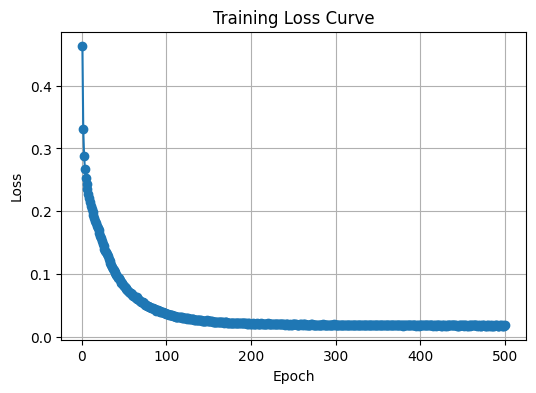

In [196]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 500, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

* 预测

In [183]:
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,device):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    
    # 增广，满足编码器的输入要求（批量大小为1）
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X)
    dec_state = net.decoder.init_state(enc_outputs)
    
    # 添加批量轴，以<bos>作为解码器的初始输入
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    
    output_seq = []
    
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
        
    return ' '.join(tgt_vocab.to_tokens(output_seq))

In [181]:
def bleu(pred_seq, label_seq, k):  #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [197]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation = predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => soyez gentil !, bleu 0.000
i'm home . => je suis chez <unk> ., bleu 0.752


## 2.注意力机制

## 3.Transformer